### Загрузка библиотек и данных

In [1]:
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv("HR.csv")

### Логистическая регрессия и предельные эффекты

Построим модель, которая предсказывает вероятность того, что сотрудник уволится (`left`), на основе степени удовлетворенности работой (`satisfaction_level`) и наличия повышения за последние 5 лет (`promotion_last_5years`):

In [3]:
logit01 = smf.logit("left ~ satisfaction_level + promotion_last_5years", data = df).fit()
print(logit01.summary())

Optimization terminated successfully.
         Current function value: 0.471291
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                14999
Model:                          Logit   Df Residuals:                    14996
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.1413
Time:                        18:28:53   Log-Likelihood:                -7068.9
converged:                       True   LL-Null:                       -8232.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.9902      0.050     20.001      0.000       0.893       1.

Можем «в чистом виде» проинтерпретировать только значимость и знаки полученных коэффициентов. Все оценки коэффициентов (`coef`) статистически значимы, p-value примерно 0 (`P>|z|`). Судя по знакам коэффициентов, вероятность того, что человек уволится, ниже для тех людей, кто больше доволен работой (-3.82) и для тех людей, которые получили повышение за последние 5 лет (-1.55). Вполне логичная ситуация.

Можно было бы проинтерпретировать полученные результаты в терминах шансов и отношения шансов, но это не всегда интуитивно, поэтому давайте перейдем к предельным эффектам, чтобы получить удобную интерпретацию, аналогичную линейной регрессии.

Для начала вычислим предельный эффект независимых переменных для среднестатистического сотрудника (независимые переменные равны среднему по выборке):

In [4]:
marg_effect_mean = logit01.get_margeff(method = "dydx", at = "mean")
print(marg_effect_mean.summary())

        Logit Marginal Effects       
Dep. Variable:                   left
Method:                          dydx
At:                              mean
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
satisfaction_level       -0.6118      0.013    -46.045      0.000      -0.638      -0.586
promotion_last_5years    -0.2476      0.039     -6.402      0.000      -0.323      -0.172


Значимость у эффектов будет такой же, как и в выдаче ранее.
    
* При прочих равных условиях (ceteris paribus – для ценителей), вероятность уволиться, в среднем, ниже на 0.61 у тех людей, у которых степень удовлетворенности работой выше на 1.
* При прочих равных условиях, вероятность уволиться, в среднем, ниже на 0.24 у тех людей, которые получили повышение за последние 5 лет работы.

Важно: эти выводы имеют место только для среднестатистического сотрудника! Выясним, для какого:

In [5]:
df.mean()

satisfaction_level         0.612834
last_evaluation            0.716102
number_project             3.803054
average_montly_hours     201.050337
time_spend_company         3.498233
Work_accident              0.144610
left                       0.238083
promotion_last_5years      0.021268
dtype: float64

Для сотрудника со степенью удовлетворенности работой 0.61 и не получавшего повышение последние за последние 5 лет (среднее для `promotion_last_5years` несильно интерпретируемо, в этом проблема среднего, но оно явно ближе к 0, чем к 1).

Аналогичным образом можем вычислить предельные эффекты независимых переменных для медианного сотрудника:

In [7]:
marg_effect_median = logit01.get_margeff(method = "dydx", at = "median")
print(marg_effect_median.summary())

        Logit Marginal Effects       
Dep. Variable:                   left
Method:                          dydx
At:                            median
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
satisfaction_level       -0.5859      0.012    -48.488      0.000      -0.610      -0.562
promotion_last_5years    -0.2371      0.038     -6.272      0.000      -0.311      -0.163


Но самый лучший способ – не вычислять эффекты для среднего или медианного сотрудника, а вычислить средний предельный эффект. Логика вычисления простая: посчитаем предельные эффекты независимых переменных для каждого человека в выборке, а потом результаты усредним. 

In [8]:
ave_marg_effect = logit01.get_margeff(method = "dydx", at = "overall")
print(ave_marg_effect.summary())

        Logit Marginal Effects       
Dep. Variable:                   left
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
satisfaction_level       -0.5822      0.010    -56.618      0.000      -0.602      -0.562
promotion_last_5years    -0.2356      0.037     -6.358      0.000      -0.308      -0.163


Интерпретация аналогична той, что выше, только здесь мы говорим о среднем эффекте для всех наблюдений – сотрудников.

### Классификация с помощью логистической регрессии

Раз логистическая регрессия позволяет предсказывать вероятности того, что зависимая переменная примет значение 1, эти предсказанные вероятности можно вычислить для каждого наблюдения в данных:

In [9]:
# вероятности того, что человек уволится, 
# для каждого сотрудника в выборке

logit01.predict()

array([0.38625298, 0.11211161, 0.63864917, ..., 0.39535773, 0.63864917,
       0.39535773])

Сохраним их в отдельный столбец датафрейма:

In [10]:
df["prob"] = logit01.predict()
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,prob
0,0.38,0.53,2,157,3,0,1,0,sales,low,0.386253
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0.112112
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0.638649
3,0.72,0.87,5,223,5,0,1,0,sales,low,0.146365
4,0.37,0.52,2,159,3,0,1,0,sales,low,0.395358


Если мы хотим решать задачу классификации и определять, относить человека к группе тех, кто уволится, или тех, кто не уволится, нам нужно определиться, какое значение предсказанной вероятности будет считаться достаточным, чтобы отнести человека в первую группу. Если нет каких-то содержательных соображений, обычно берут пороговое значение 0.5. Поступим так же и посмотрим, что получится в случае наших данных:

In [11]:
df["model"] = (df["prob"] > 0.5).astype(int)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,prob,model
0,0.38,0.53,2,157,3,0,1,0,sales,low,0.386253,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0.112112,0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0.638649,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,0.146365,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0.395358,0


Итак, в столбце `left` реальные значения – увольнялись ли сотрудники или нет, а в столбце `model` – предсказанные значения, считаем ли мы на основе построенной модели и выбранного порога, что человек увольнялся, или нет. 

Можем оценить качество нашей классификации – насколько мы ошибаемся в предсказании 0 и 1. Построим *confusion matrix* или попросту таблицу сопряженности для реальных и предсказанных значений:

In [12]:
# по строкам – реальные значения
# по столбцам – предсказанные моделью

tab = pd.crosstab(df["left"], df["model"])
tab

model,0,1
left,,
0,10607,821
1,2640,931


Посчитаем на основе этой таблицы чувствительность и специфичность модели:

In [14]:
TN = tab.iloc[0, 0]  # true negative
TP = tab.iloc[1, 1]  # true positive
FN = tab.iloc[1, 0]  # false nagative
FP = tab.iloc[0, 1]  # false positive

In [15]:
sensitivity = TP / (TP + FN)  # true positive rate
specificity = TN / (TN + FP)  # true negative rate
print(sensitivity, specificity)

0.2607112853542425 0.9281589079453972


Чувствительность модели при выбранном пороговом значениии 0.5 не очень хорошая, что неудивительно – в выборке явный «перекос» в сторону нулей:

In [16]:
df["left"].value_counts()

0    11428
1     3571
Name: left, dtype: int64

Видимо, пороговое значение нужно брать не 0.5, а пониже, исходя из того, что соотношение 0 и 1 в выборке далеко не 50 на 50, нулей в 3 раза больше. Но мы сейчас заниматься этим не будем, это небольшое отступление про классификацию нам понадобилось для того, чтобы мы могли более осмысленно построить графики для оценки предсказательной силы модели.

### Предсказательная сила модели: ROC кривая и AUC

Для построения ROC кривой и вычисления площади под ней (AUC, *area under curve*), нам понадобятся соответствующие функции из модуля `metrics` библиотеки `sklearn`:

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

Функция `roc_curve()` вычисляет *false positive rate* и *true positive rate* для разных пороговых значений, которые мы можем выбрать для дальнейшей классификации (ранее в примере мы выбрали 0.5, а теоретически могли взять любое значение от 0 до 1).

In [18]:
fpr, tpr, thresholds = roc_curve(df["left"], df["prob"])

In [20]:
thresholds[0:10] # 10 пороговых значений, первое даже больше 1, но это нестрашно

array([1.65610729, 0.65610729, 0.64742744, 0.63864917, 0.62977733,
       0.62081699, 0.61177347, 0.60265231, 0.59345927, 0.58420027])

In [21]:
fpr[0:10]  # false positive rate для каждого из 10 пороговых значений выше

array([0.        , 0.        , 0.        , 0.        , 0.00227511,
       0.00673784, 0.01225061, 0.01828841, 0.02450123, 0.03036402])

In [22]:
tpr[0:10]  # true positive rate для каждого из 10 пороговых значений выше

array([0.        , 0.05460655, 0.15485858, 0.24782974, 0.24894987,
       0.24978997, 0.25259031, 0.25343041, 0.25371045, 0.25511061])

Заодно вычислим сводную меру качества модели – площадь под ROC кривой, AUC:

In [23]:
auc = roc_auc_score(df["left"], df["prob"])
auc  # довольно хорошее качество!

0.7510613489229488

Импортируем модуль `pyplot` из `matplotlib` и нанесем полученные выше значения на график – построим ROC кривую.

In [24]:
from matplotlib import pyplot as plt

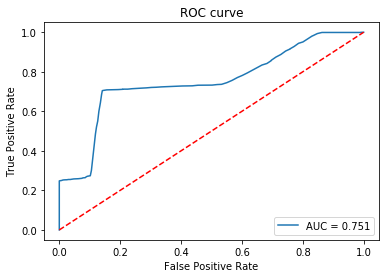

In [26]:
plt.figure()

# добавляем точки, соединенные линией, 
# по оси x идет fpr, по оси y идет tpr
# label нужен для того, чтобы отразить в легенде графика AUC,
# AUC окргулен до 3 знаков через форматирование %.3f


plt.plot(fpr, tpr, label = 'AUC = %.3f' % auc)

# добавляем диагональную линию, она идет из точки (0, 0) в точку (1, 1), 
# это задается в виде списков [0, 1] и [0, 1]
# первые элементы – координаты точек по x, вторые – по y
# линия красная (r от red) и пунктирная

plt.plot([0, 1], [0, 1],'r--')

# добавляем подписи по осям, заголовок и легенду

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right")
plt.show()

Если мы хотим сравнить качество двух и более моделей на основе ROC и AUC, можно нанести сразу несколько кривых на график. Предположим, что у нас есть новая модель, которая включает в себя гораздо больше факторов:

In [28]:
logit02 = smf.logit("left ~ satisfaction_level + number_project + promotion_last_5years + salary + average_montly_hours", 
                    data = df).fit()

Optimization terminated successfully.
         Current function value: 0.453254
         Iterations 7


Добавим в датафрейм новые предсказанные вероятности, уже согласно этой модели, а затем посчитаем для нее все характеристики, которые мы определяли для предыдущей модели:

In [30]:
df["prob2"] = logit02.predict()
fpr2, tpr2, thresholds2 = roc_curve(df["left"], df["prob2"])
auc2 = roc_auc_score(df["left"], df["prob2"])

Осталось построить ROC кривую и добавить ее на предыдущий график. Код тот же, добавится только еще одна строка с `plot()`:

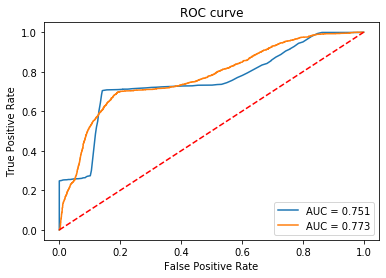

In [31]:
plt.figure()

# теперь две модели – две кривые, 
# Python сам сделаем их разного цвета

plt.plot(fpr, tpr, label = 'AUC = %.3f' % auc)
plt.plot(fpr2, tpr2, label = 'AUC = %.3f' % auc2)

plt.plot([0, 1], [0, 1],'r--')

# добавляем подписи по осям, заголовок и легенду

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right")
plt.show()

Ура! Видим, что вторая модель чисто по качеству получилась получше, предсказательная сила у нее выше.